# Blackbox Fast Gradient Signed Method adversarial attack on MNIST dataset


Blackbox FSGM attack is not much different from whitebox approach. 

As we don't have access to the "victim's" neural net, we base the attack on the idea, that if we train a nn similar enough to the target, adversarial examples trained on our network will have similar impact on target.

Example below aims to show that approach on MNIST dataset.

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from matplotlib import pyplot as plt

Using TensorFlow backend.


## MNIST dataset


5


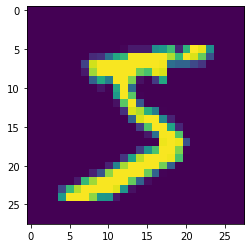

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(y_train[0])
plt.imshow(x_train[0])

## 1. Creating target neural network (target_model)

We are going to use convolutional neural network achieving 99.7% accuracy from Kaggle Contest. We assume, that all network paramters are unknown and treat it like input/output 'blackbox'.

Source:
https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook

License: Apache 2.0

In [210]:
(X_train, Y_train), (X_val, Y_val) = mnist.load_data()
X_train, X_val = X_train / 255.0, X_val / 255.0
Y_train = to_categorical(Y_train, num_classes = 10)
Y_val = to_categorical(Y_val, num_classes = 10)
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_val= X_val.reshape(X_val.shape[0],28,28,1)

In [211]:
target_model = Sequential()
target_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
target_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
target_model.add(MaxPool2D(pool_size=(2,2)))
target_model.add(Dropout(0.25))
target_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
target_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
target_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
target_model.add(Dropout(0.25))
target_model.add(Flatten())
target_model.add(Dense(256, activation = "relu"))
target_model.add(Dropout(0.5))
target_model.add(Dense(10, activation = "softmax"))

In [212]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
target_model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [213]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86
validation_batch_size = batch_size

history = target_model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_val,Y_val),
                              verbose = 1, 
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])

Epoch 1/1
697/697 [==============================] - 141s 203ms/step - loss: 0.3245 - accuracy: 0.8976 - val_loss: 0.0323 - val_accuracy: 0.9901


In [173]:
target_model.evaluate(X_val, Y_val, verbose=2)

[0.04789765243367292, 0.9854000210762024]

In [193]:
# exp_x = x_test.reshape(x_test.shape[0],28,28,1)
# exp_image = exp_x[3]
# print(exp_image.shape)
# exp_image = exp_x[3].reshape(1,28,28,1)


# orig = X_val[3]
# print(orig.shape)
# orig = orig.reshape(1,28,28,1)
# image = x_test[3]
# print(image.shape)

# image = image.reshape(1,28,28,1)
# print(image.shape)
# print("target model: " + str(target_model.predict(exp_image).argmax(axis=1)))
# print("target model: " + str(target_model.predict(orig).argmax(axis=1)))
# print("target model: " + str(target_model.predict(image).argmax(axis=1)))

# plt.imshow(exp_image[0,:,:,0])
# plt.show()
# plt.imshow(orig[0,:,:,0])
# plt.show()
# plt.imshow(image[0,:,:,0])
# plt.show()

(X_train, Y_train), (X_val, Y_val) = mnist.load_data()
print(X_val[3].shape)


X_val= X_val.reshape(X_val.shape[0],28,28,1)
X_val[3] = 
new_orig = new_orig.reshape(1,28,28,1)
print("target model: " + str(target_model.predict(new_orig).argmax(axis=1)))


(28, 28)
target model: [0]


## 2. Creating dummy neural netowrk from scrach (dummy_model)

We are going to create a simple 2-layer deep neural network using Tensorflow sequential model.

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [9]:
dummy_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

The `losses.SparseCategoricalCrossentropy` loss takes a vector of logits and a `True` index and returns a scalar loss for each example.

This loss is equal to the negative log probability of the true class: It is zero if the model is sure of the correct class.
This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to -tf.log(1/10) ~= 2.3.

In [38]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [39]:
dummy_model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
dummy_model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.0678 - accuracy: 0.9783
Epoch 2/5
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0567 - accuracy: 0.9819
Epoch 3/5
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0525 - accuracy: 0.9822
Epoch 4/5
60000/60000 [==============================] - 3s 43us/sample - loss: 0.0478 - accuracy: 0.9845
Epoch 5/5
60000/60000 [==============================] - 2s 40us/sample - loss: 0.0452 - accuracy: 0.9848


In [40]:
dummy_model.evaluate(x_test,  y_test, verbose=2)

10000/10000 - 0s - loss: 0.0688 - accuracy: 0.9799


[0.0688444945413852, 0.9799]

The image classifier is now trained to ~97%.

Attaching softmax to nn output

In [41]:
dummy_probability_model = tf.keras.Sequential([
  dummy_model,
  tf.keras.layers.Softmax()
])

## 3. Creating FGSM adversarial attack

In [42]:
def create_adversarial_pattern(input_image, input_label, model, loss_object):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

We know, that dummy network uses sparse categorical crossentropy, so we are going to use that.

Test image:


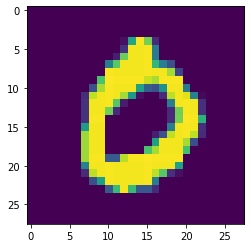

Label:0
Perturbations:


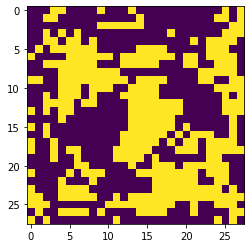

In [201]:
image = x_test[3:4]
label = y_test[3]
print("Test image:")
plt.imshow(image[0])
plt.show()
print("Label:"+ str(label))

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

tensor_one_hot_y = tf.one_hot(label, 10)
tensor_one_hot_y = tf.reshape(tensor_one_hot_y, (1, 10))
tensor_image = tf.convert_to_tensor(image)
perturbations = create_adversarial_pattern(
    tensor_image, tensor_one_hot_y, dummy_probability_model, loss)

print("Perturbations:")
plt.imshow(perturbations[0])

Image perturbations were succcesfully computed.
We can test adversarial example against target nn.

0
dummy model: [0]
target model: [0]


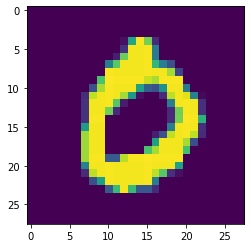

0.01
dummy model: [0]
target model: [0]


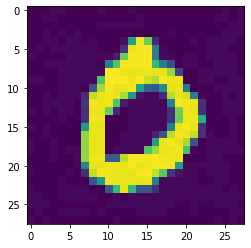

0.1
dummy model: [7]
target model: [0]


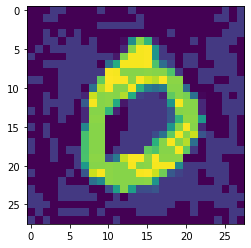

0.15
dummy model: [7]
target model: [0]


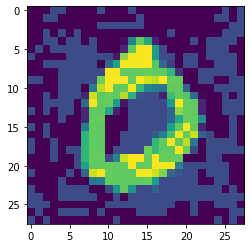

0.3
dummy model: [2]
target model: [2]


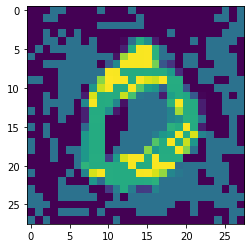

0.6
dummy model: [2]
target model: [3]


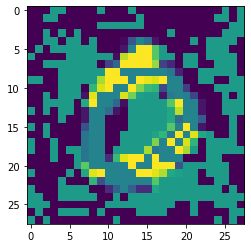

0.8
dummy model: [2]
target model: [3]


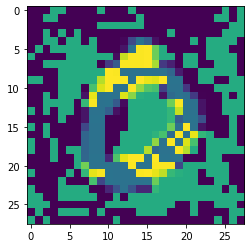

1.0
dummy model: [2]
target model: [3]


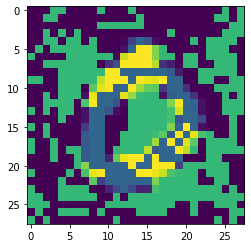

1.2
dummy model: [1]
target model: [3]


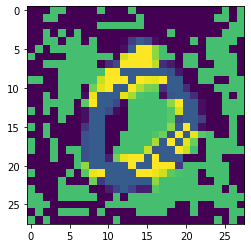

In [221]:
epsilons = [0, 0.01, 0.1, 0.15, 0.30, 0.60, 0.8, 1.0, 1.2]
for i, eps in enumerate(epsilons):
    print(eps)
    adv_x = image + eps*perturbations
    print("dummy model: " + str(dummy_probability_model(adv_x).numpy().argmax(axis=1)))   
    (X_train, Y_train), (X_val, Y_val) = mnist.load_data()
    X_train, X_val = X_train / 255.0, X_val / 255.0
    X_val[3] = X_val[3] + eps*perturbations
    X_val= X_val.reshape(X_val.shape[0],28,28,1)
    target_x = X_val[3].reshape(1,28,28,1)
    print("target model: " + str(target_model.predict(target_x).argmax(axis=1)))
    
    plt.imshow(adv_x[0])
    plt.show()

Perturbations worked on dummy network at eps = 0.1, target was harder to fool, wrong output occured at eps = 0.3, image perturbations are clearly visible at this point so method works in theory but requires better implementation in practice